In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install ultralytics pycocotools -q
print("✅ Ultralytics and Pycocotools installed successfully.")


import os
import yaml
import torch
import glob
from ultralytics import YOLO
from IPython.display import Image, display

✅ Ultralytics and Pycocotools installed successfully.


In [3]:
print("\nPyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU. This will be very slow.")


PyTorch version: 2.6.0+cu124
CUDA available: True
Using device: Tesla T4


In [4]:
# Define the path to the dataset on Kaggle
dataset_base_path = '/kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8'

# Create the data configuration dictionary for 3 classes
data_config = {
    'path': dataset_base_path,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': {
        0: 'glioma',
        1: 'meningioma',
        2: 'pituitary'
    }
}

# Write the dictionary to a YAML file in the current working directory
config_path = './brain_tumor_data.yaml'
with open(config_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=None)

print("\nDataset configuration file created at:", config_path)


Dataset configuration file created at: ./brain_tumor_data.yaml


In [5]:
# Load a pre-trained YOLOv8n model (a small, fast, and powerful variant)
# This will serve as our "YOLOv11" baseline.
model = YOLO('yolov8n.pt')

print("\n Starting YOLOv11 training...")
# Train the model using the Python API
# Epochs are set to 20 for a test run. Increase to 100+ for the final project.
results = model.train(
    data=config_path,
    epochs=20,
    imgsz=640,
    batch=-1,  # Auto-batch size
    device=0,
    project='yolov11_training',
    name='brain_tumor_baseline_3class'
)


 Starting YOLOv11 training...
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./brain_tumor_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brain_tumor_baseline_3class, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        612        612      0.899      0.817      0.904      0.695
                glioma        285        285      0.831      0.663      0.797       0.54
            meningioma        142        142      0.992      0.907      0.976      0.811
             pituitary        185        185      0.875      0.881      0.939      0.733
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to yolov11_training/brain_tumor_baseline_3class


In [6]:
print("\n Starting YOLOv11 validation on the test set...")
# The 'train' method already returns the best model, so we can use that object directly.
# The best model weights are also saved automatically, but this is more direct.
val_results = model.val(
    split='test',
    project='yolov11_validation',
    name='test_results'
)


 Starting YOLOv11 validation on the test set...
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4.2±0.9 MB/s, size: 31.1 KB)
val: Scanning /kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8/test/labels... 308 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 308/308 156.2it/s 2.0s
WARNING ⚠️ val: Cache directory /kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 1.1it/s 5.5ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        308        308      0.849      0.871      0.904      0.684
                glioma        159        159      0.714      0.723      0.769      0.513
            meningioma         62         62      0.922      0.955      0.972      0.816
             pituitary         87         87       0.91      0.935      0.972      0.724
Speed: 3.8ms preprocess, 4.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to yolov11_validation/test_results


In [18]:
# The 'results.save_dir' attribute contains the path to all output files.
results_dir = results.save_dir
print(f"\n Displaying results from: {results_dir} ---")

# --- Debugging Step: List all files in the results directory ---
print("\n[DEBUG] Files found in the results directory:")
try:
    for filename in os.listdir(results_dir):
        print(f"- {filename}")
except FileNotFoundError:
    print(f"Error: The directory '{results_dir}' does not exist.")


📂 --- Displaying results from: yolov11_training/brain_tumor_baseline_3class ---

[DEBUG] Files found in the results directory:
- train_batch2.jpg
- confusion_matrix.png
- train_batch1.jpg
- BoxF1_curve.png
- BoxR_curve.png
- BoxPR_curve.png
- train_batch360.jpg
- train_batch362.jpg
- train_batch0.jpg
- val_batch2_pred.jpg
- val_batch0_labels.jpg
- confusion_matrix_normalized.png
- results.png
- val_batch2_labels.jpg
- labels.jpg
- val_batch1_pred.jpg
- results.csv
- args.yaml
- val_batch1_labels.jpg
- weights
- BoxP_curve.png
- val_batch0_pred.jpg
- train_batch361.jpg



 Training & Validation Metrics (Loss, mAP, etc.)


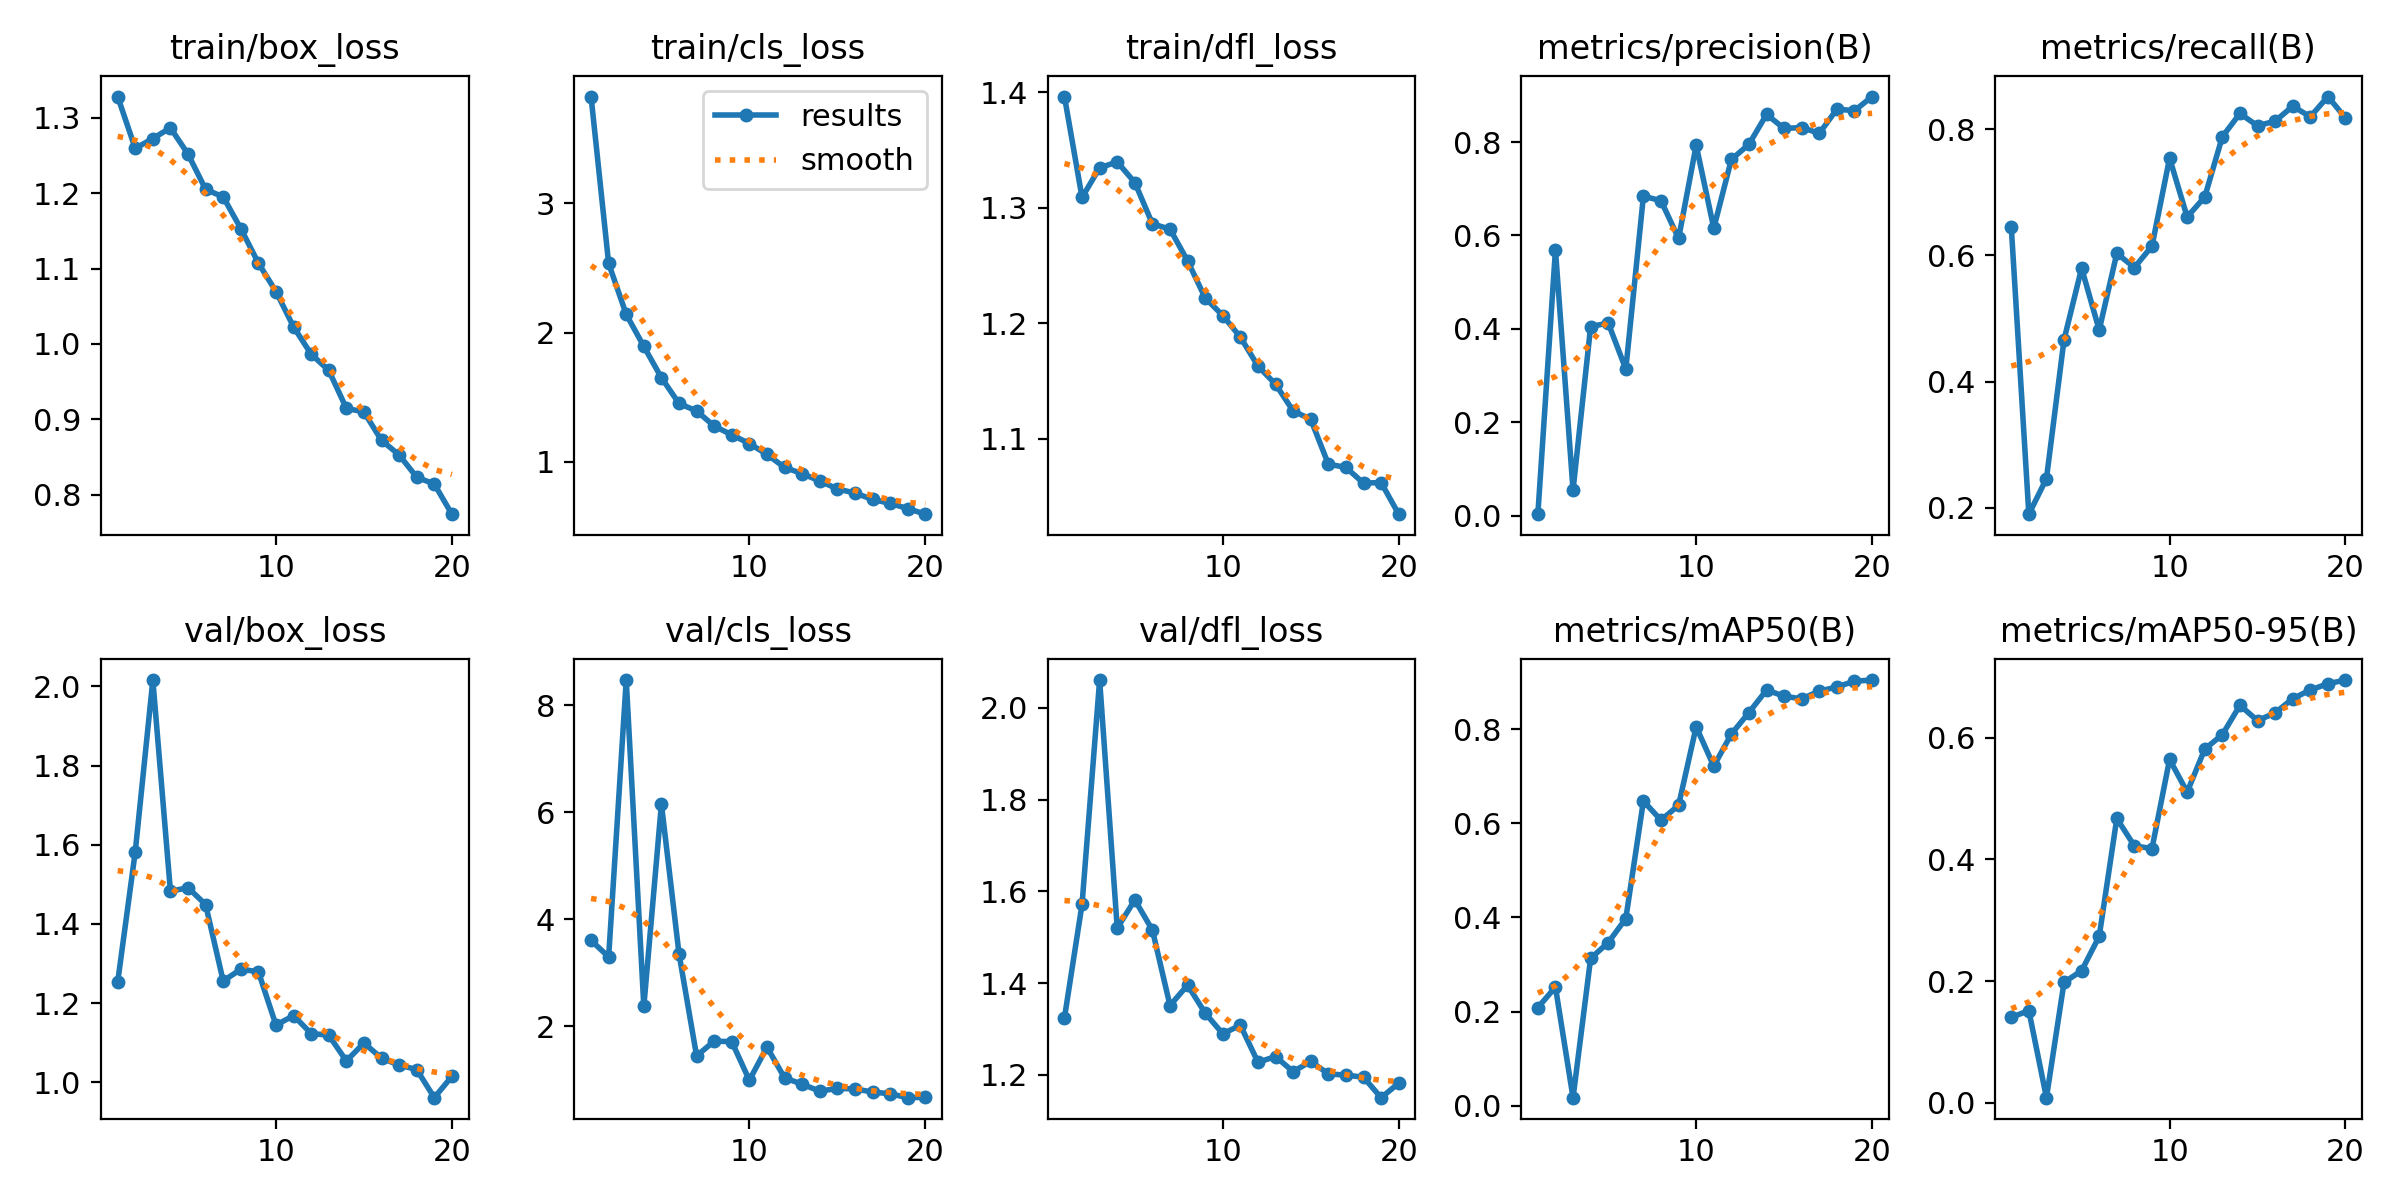

In [20]:
# 6.1 Training & Validation Metrics
results_plot_path = os.path.join(results_dir, 'results.png')
if os.path.exists(results_plot_path):
    print("\n Training & Validation Metrics (Loss, mAP, etc.)")
    display(Image(filename=results_plot_path, width=1200))
else:
    print(f"Could not find results plot at: {results_plot_path}")


 Confusion Matrix


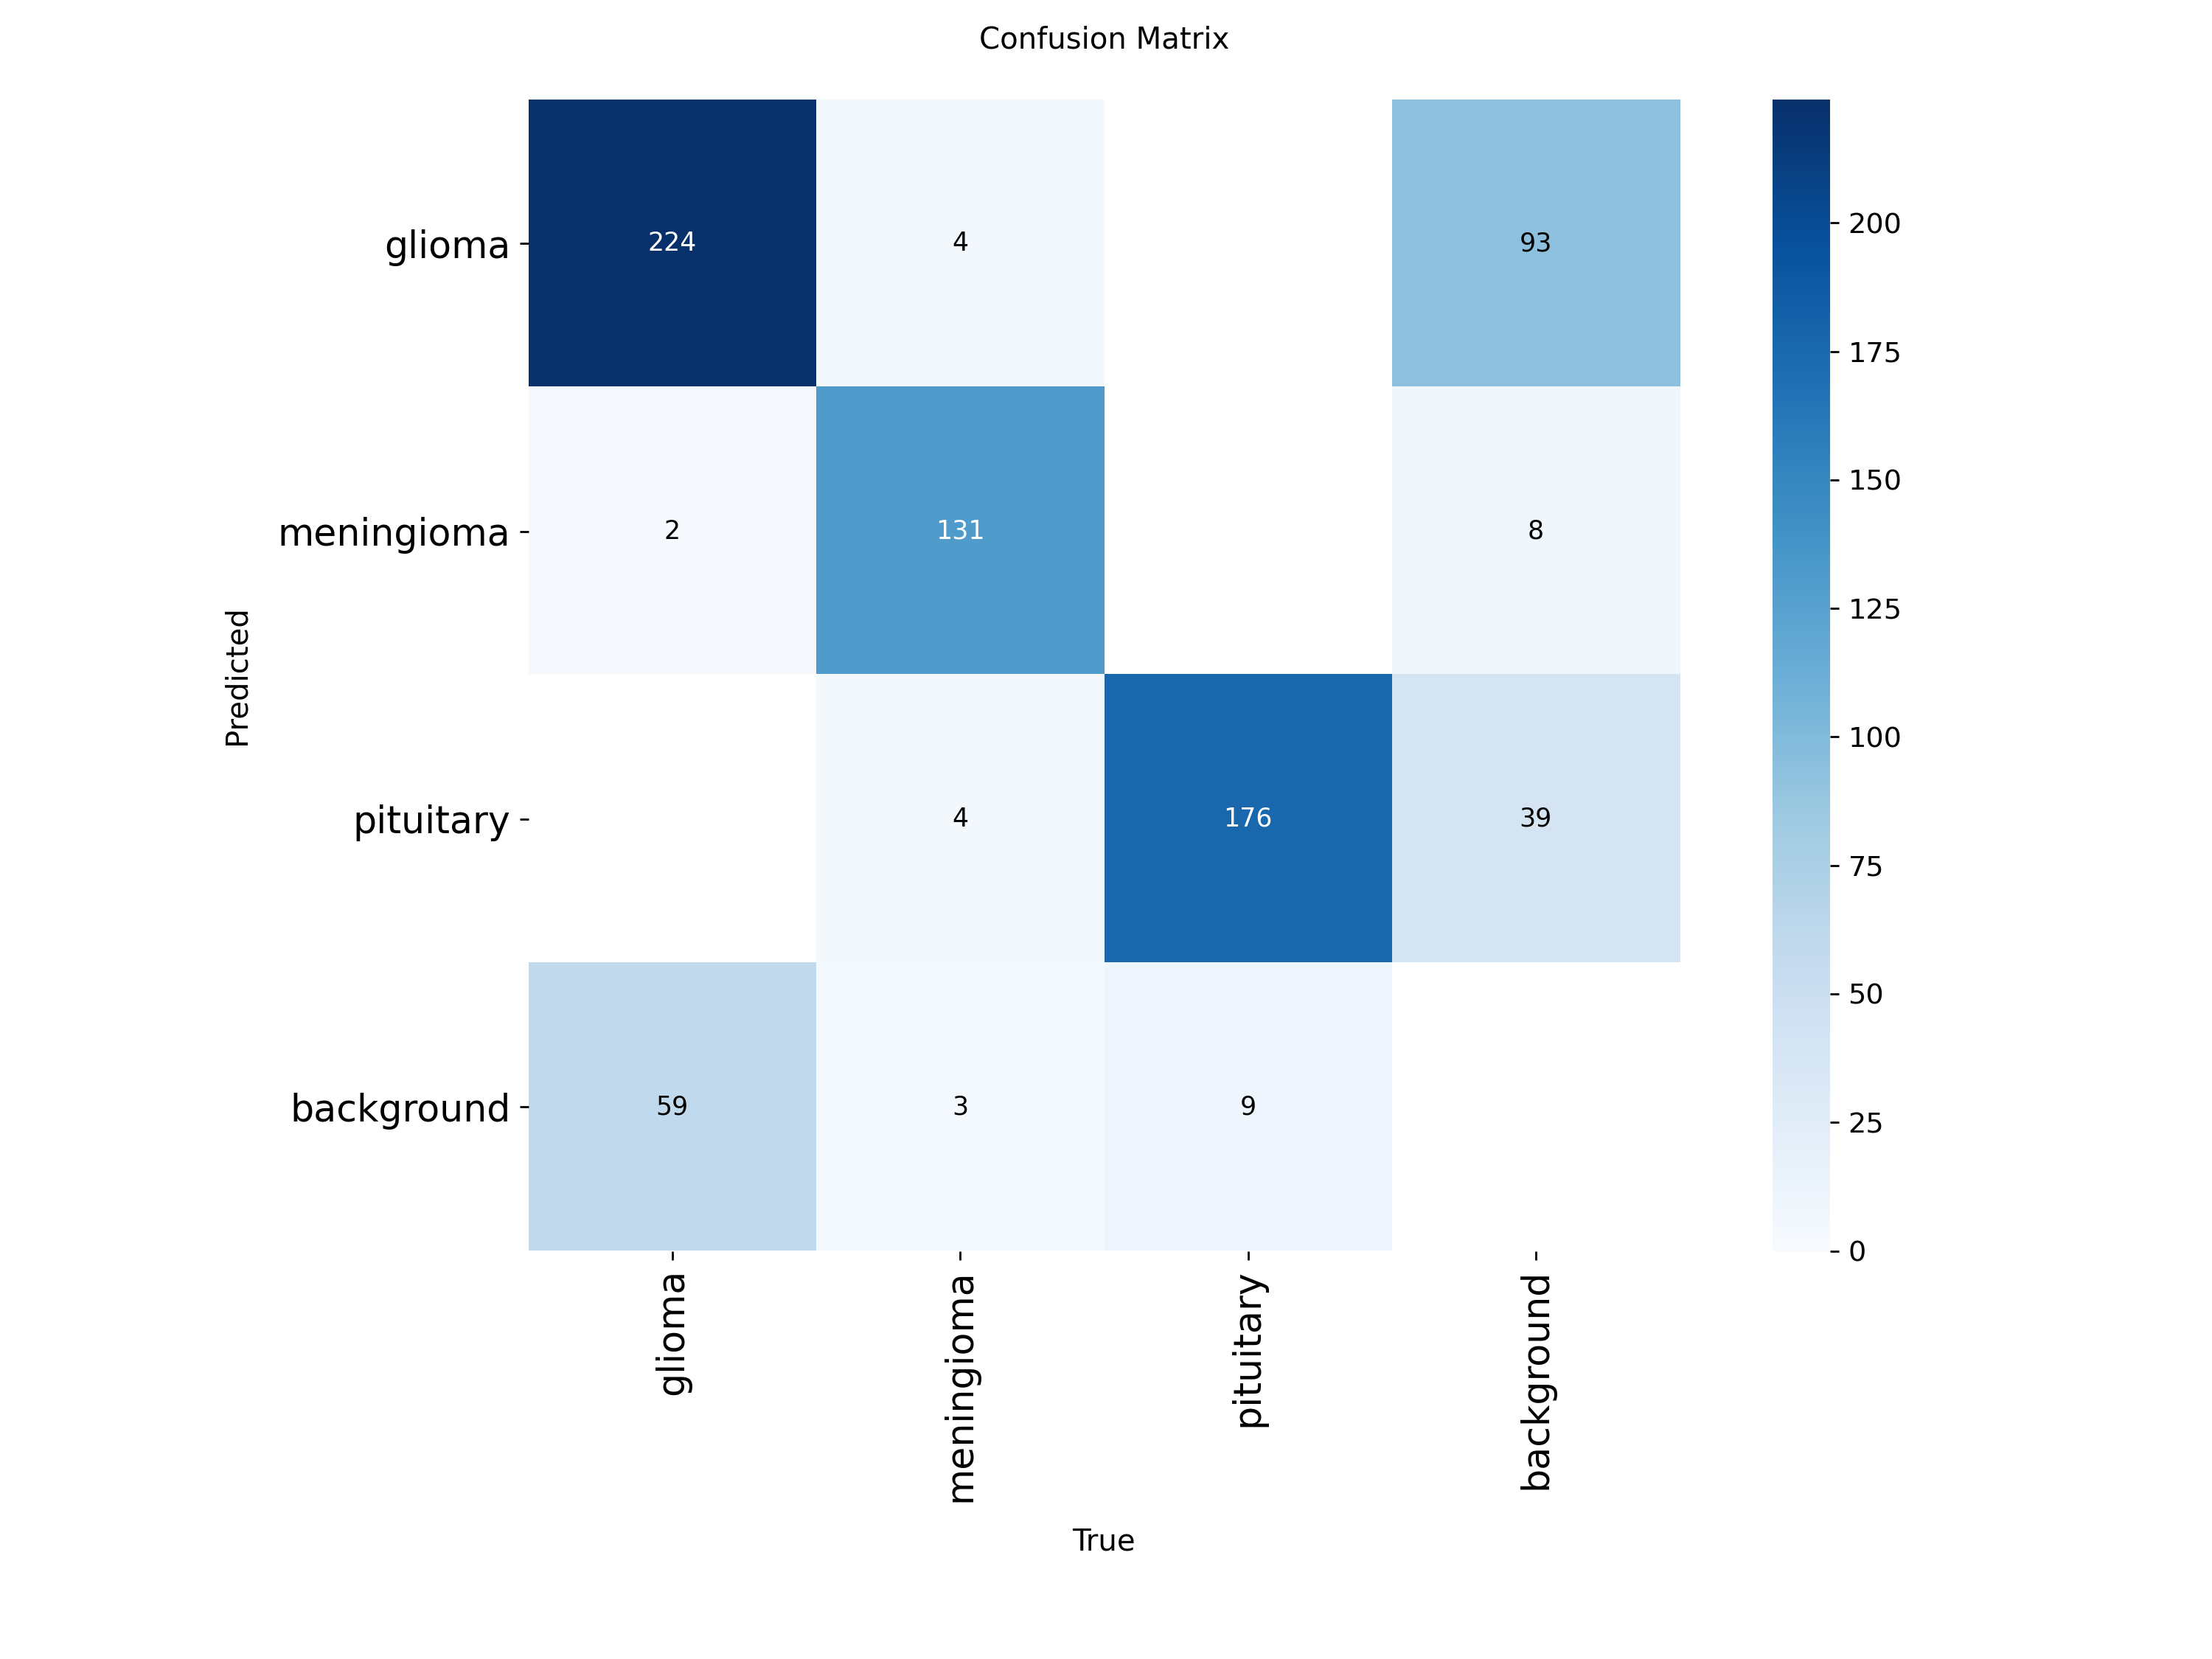

In [22]:
# 6.2 Confusion Matrix
confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')
if os.path.exists(confusion_matrix_path):
    print("\n Confusion Matrix")
    display(Image(filename=confusion_matrix_path, width=1000))
else:
    print(f"Could not find confusion matrix at: {confusion_matrix_path}")



Precision-Recall (PR) Curve


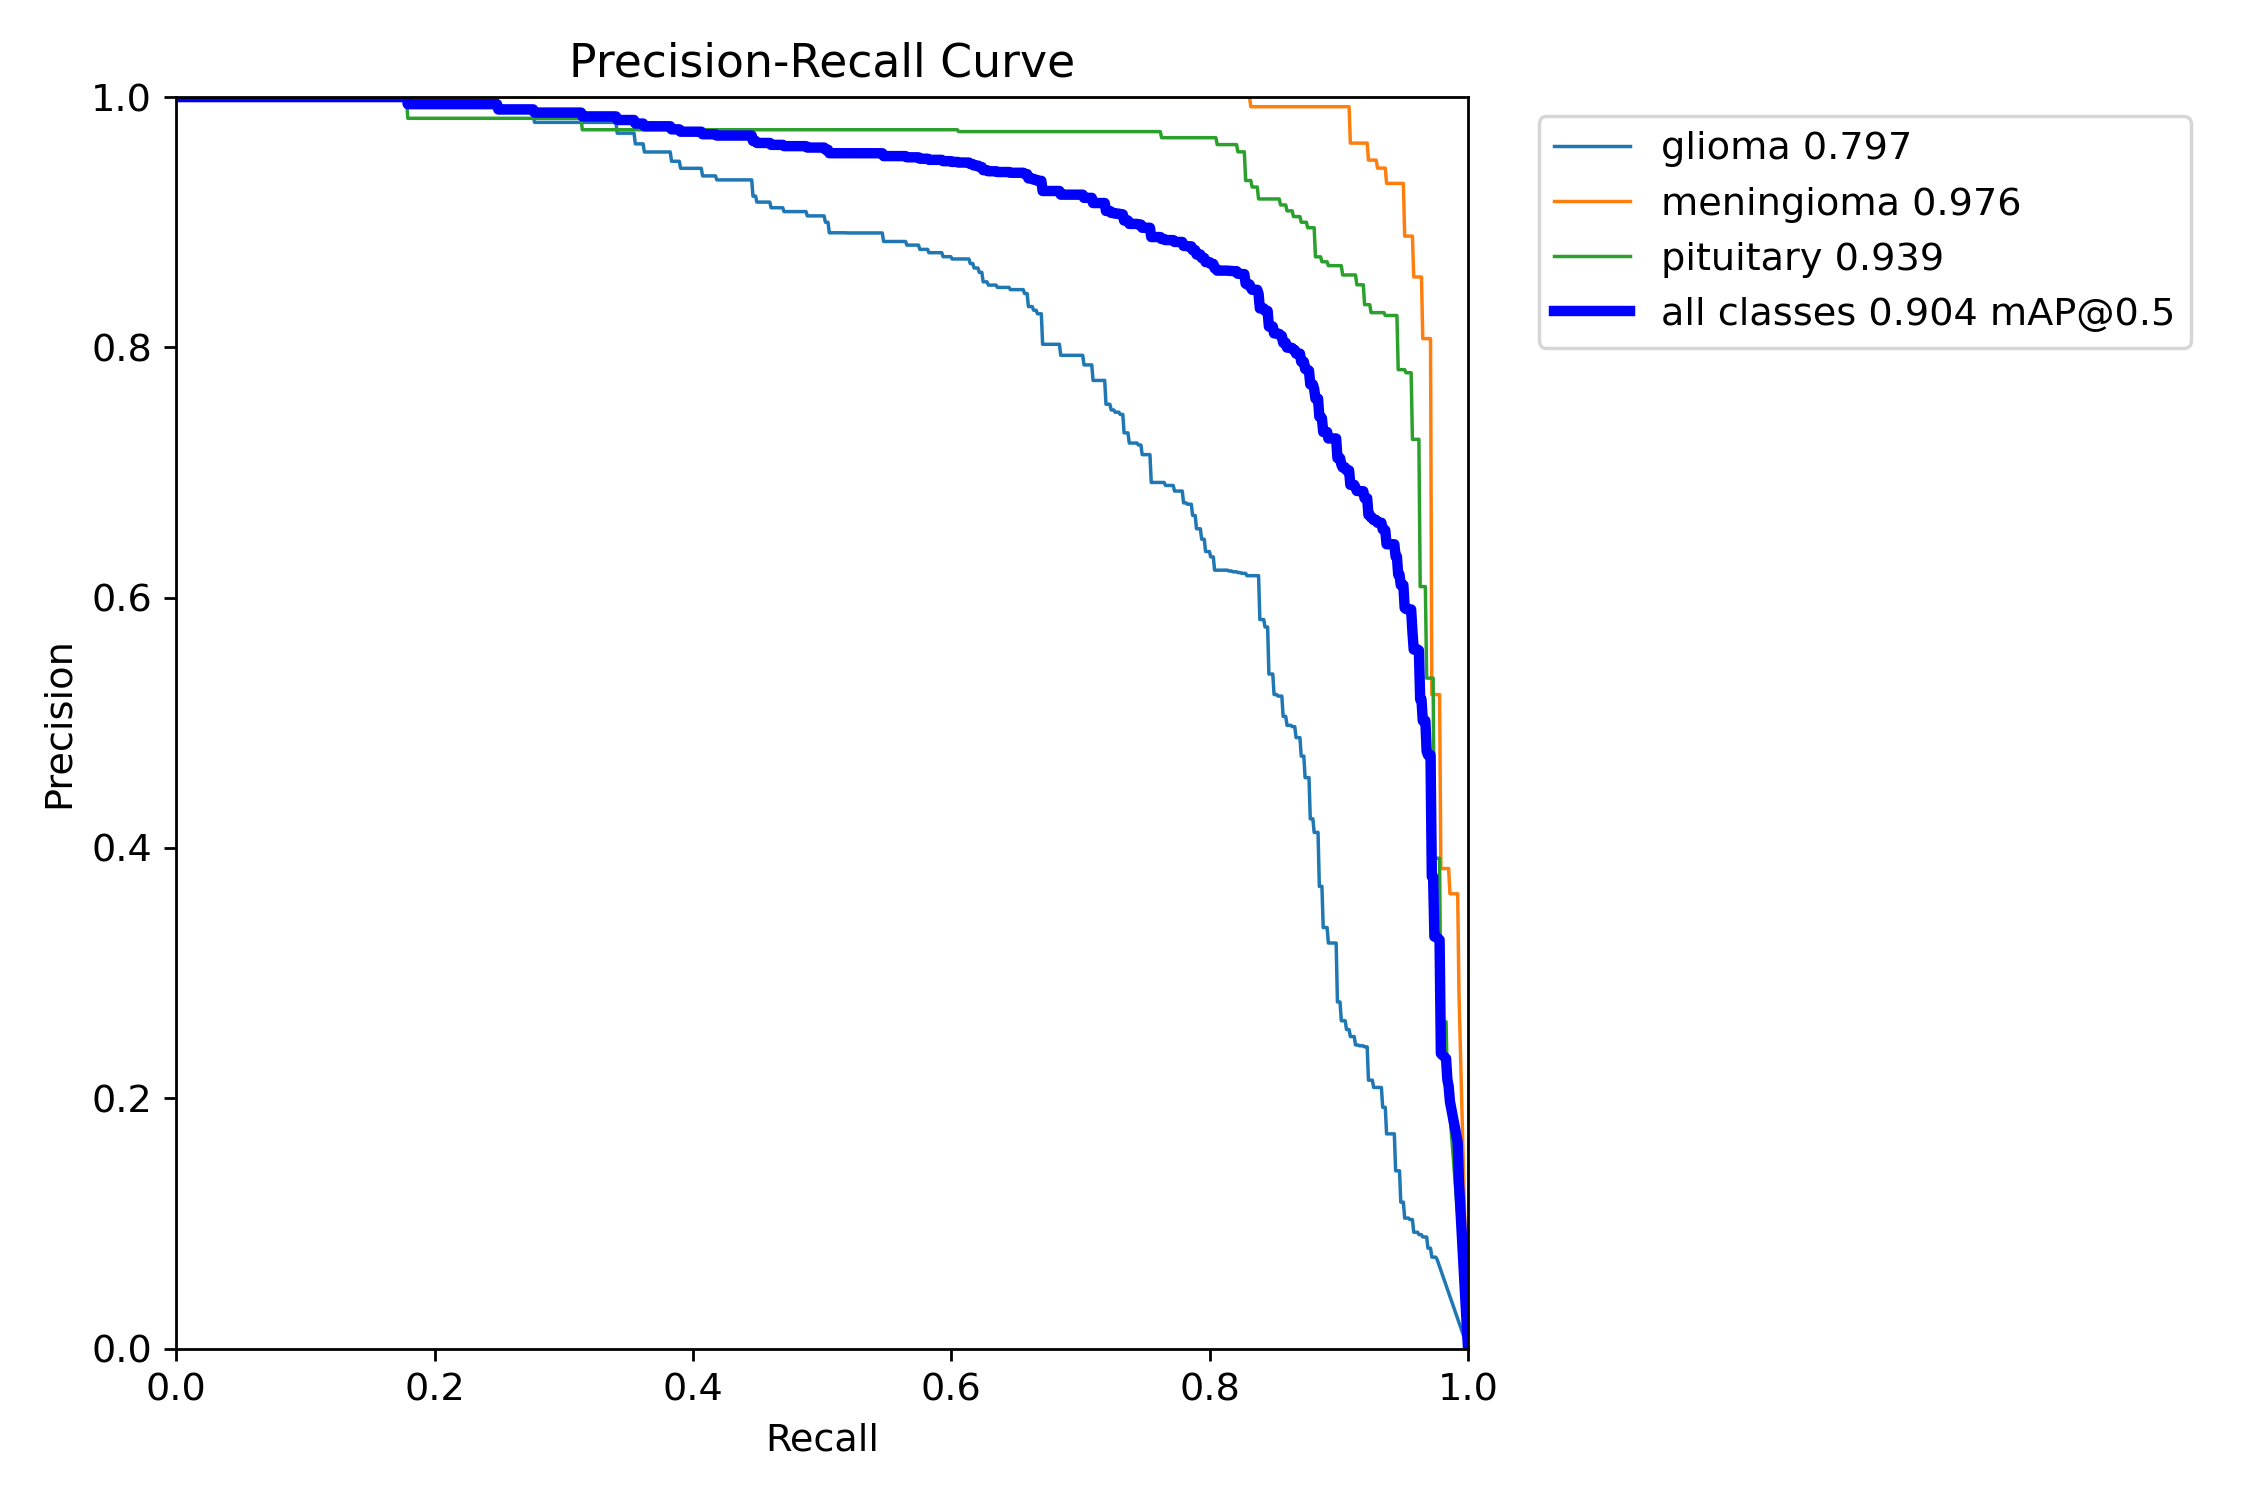

In [24]:
# 6.3 Precision-Recall (PR) Curve
# FIXED: Use glob to find the PR curve robustly, as the exact name can vary.
print("\nPrecision-Recall (PR) Curve")
pr_curve_path = glob.glob(os.path.join(results_dir, '*PR_curve.png'))
if pr_curve_path:
    display(Image(filename=pr_curve_path[0], width=1000))
else:
    print(f"Could not find a PR curve plot in: {results_dir}")


Sample Predictions from Validation


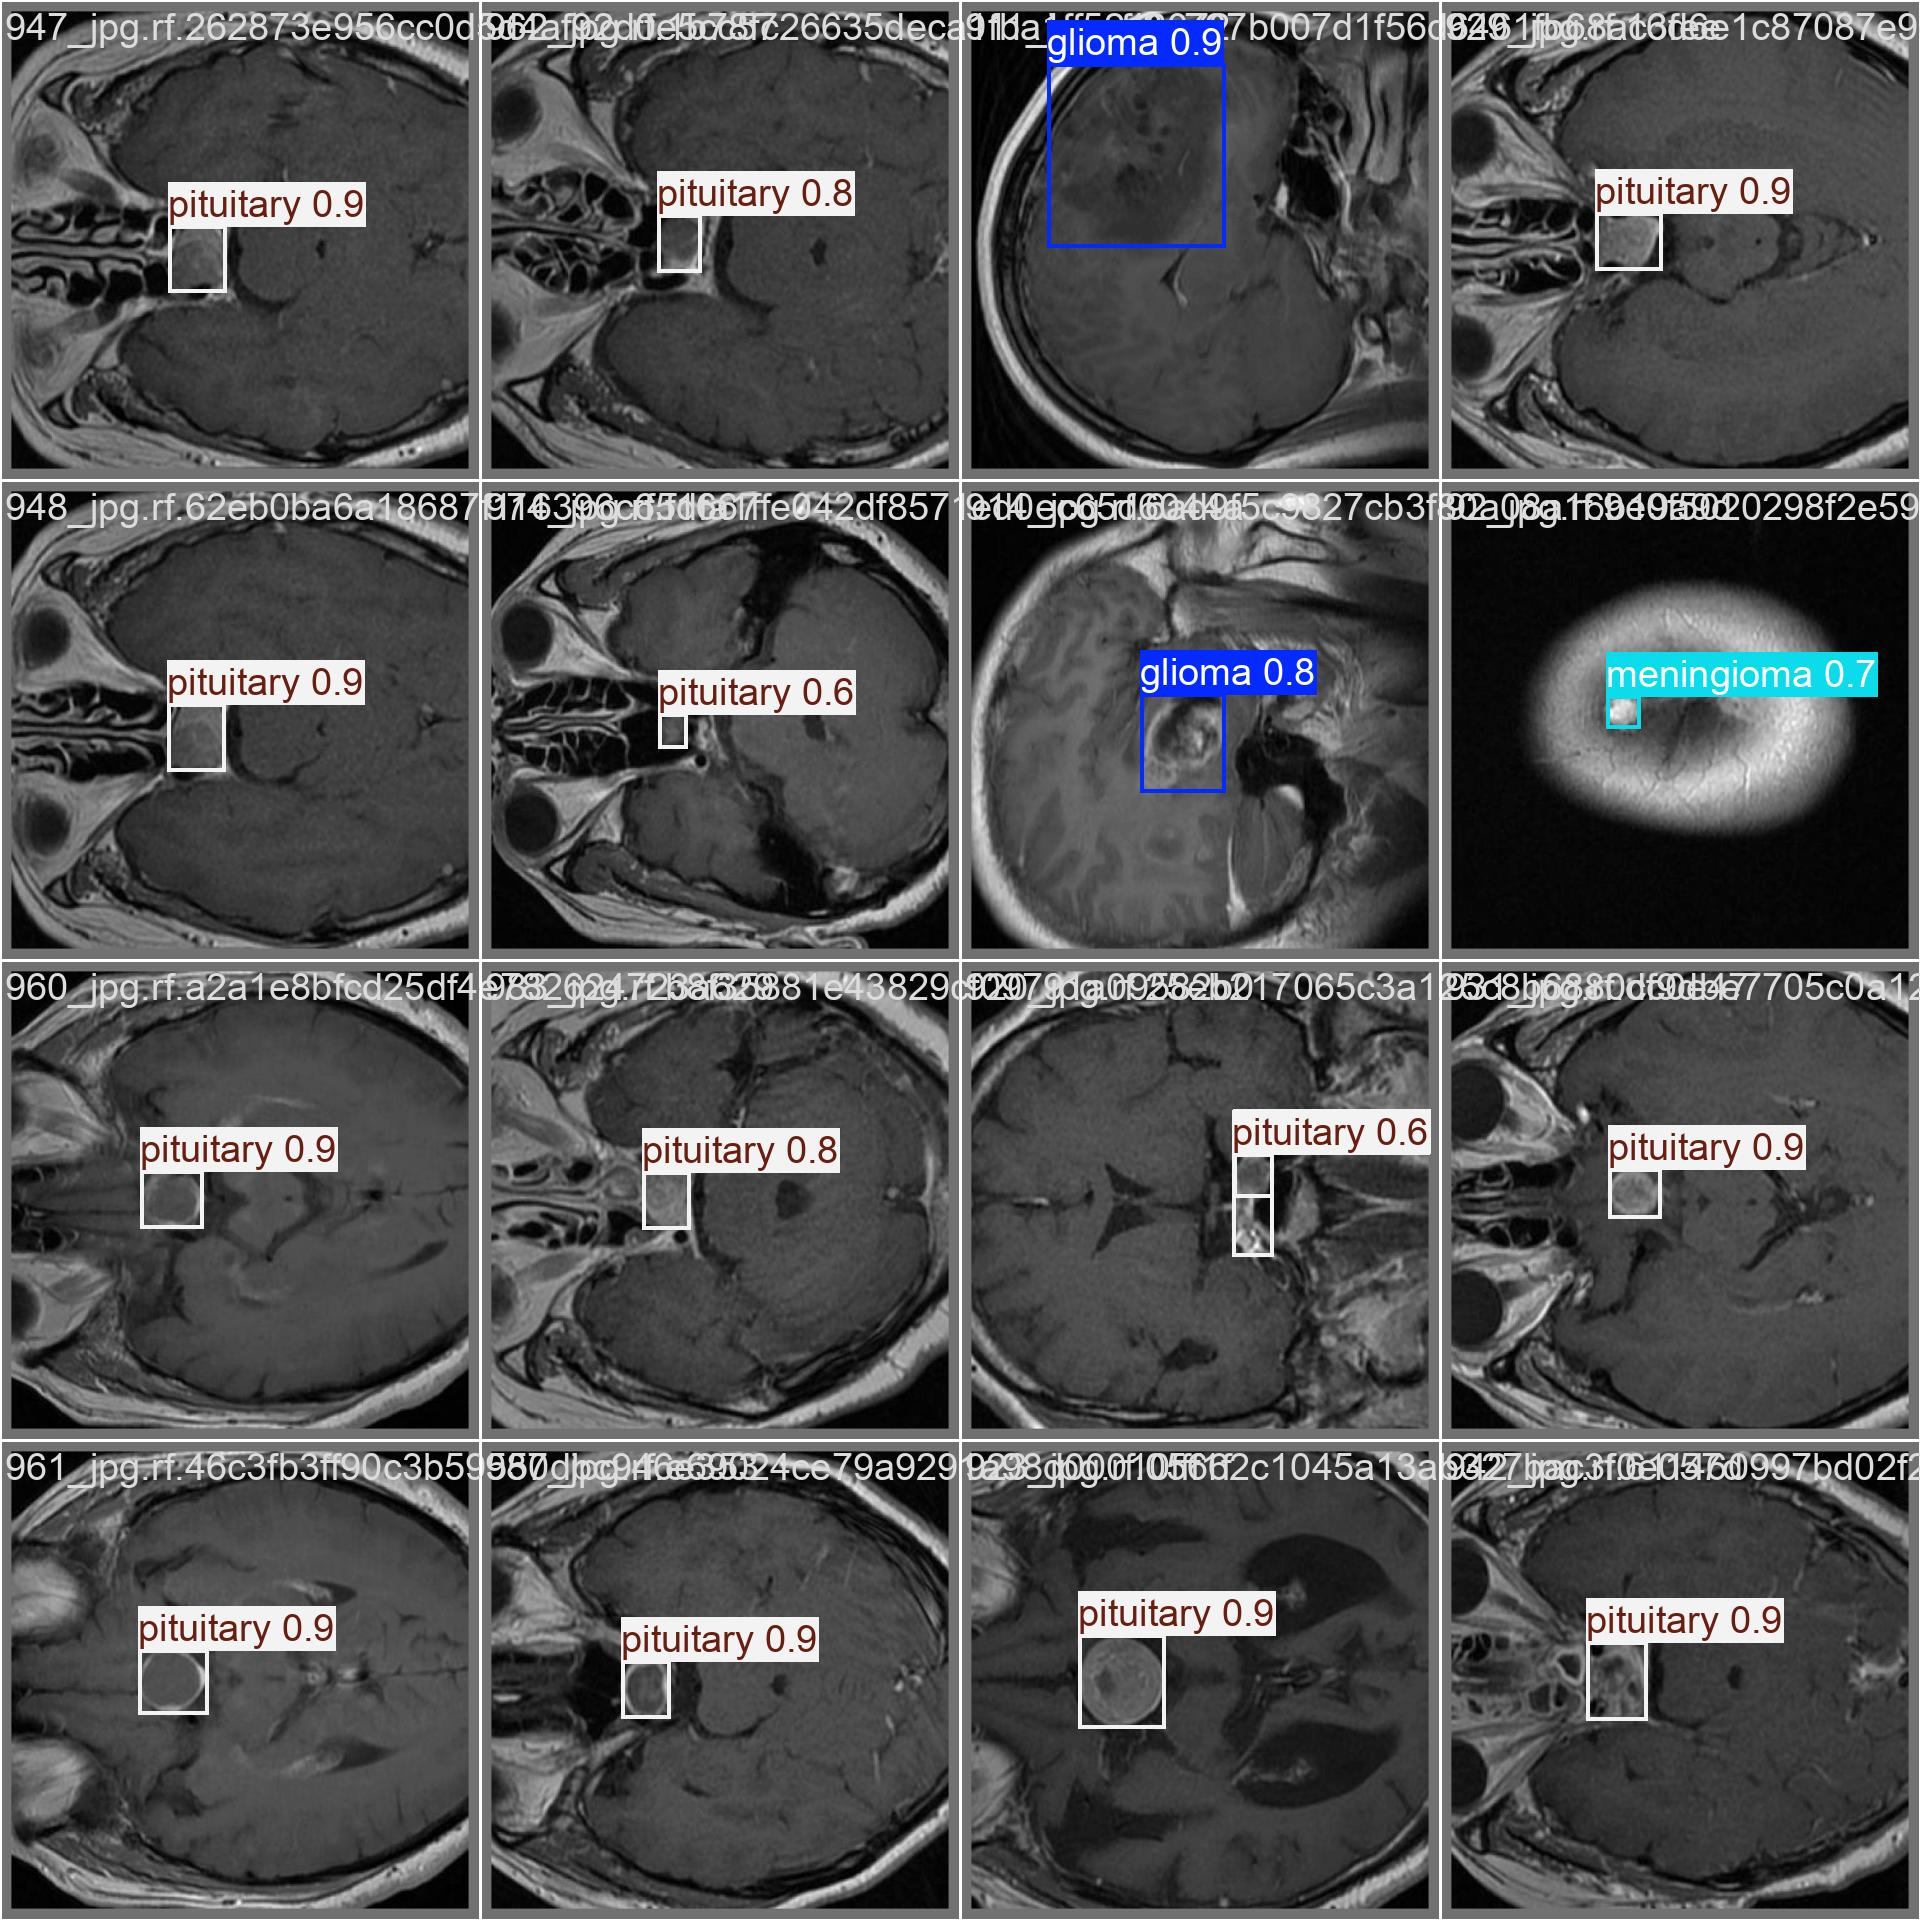

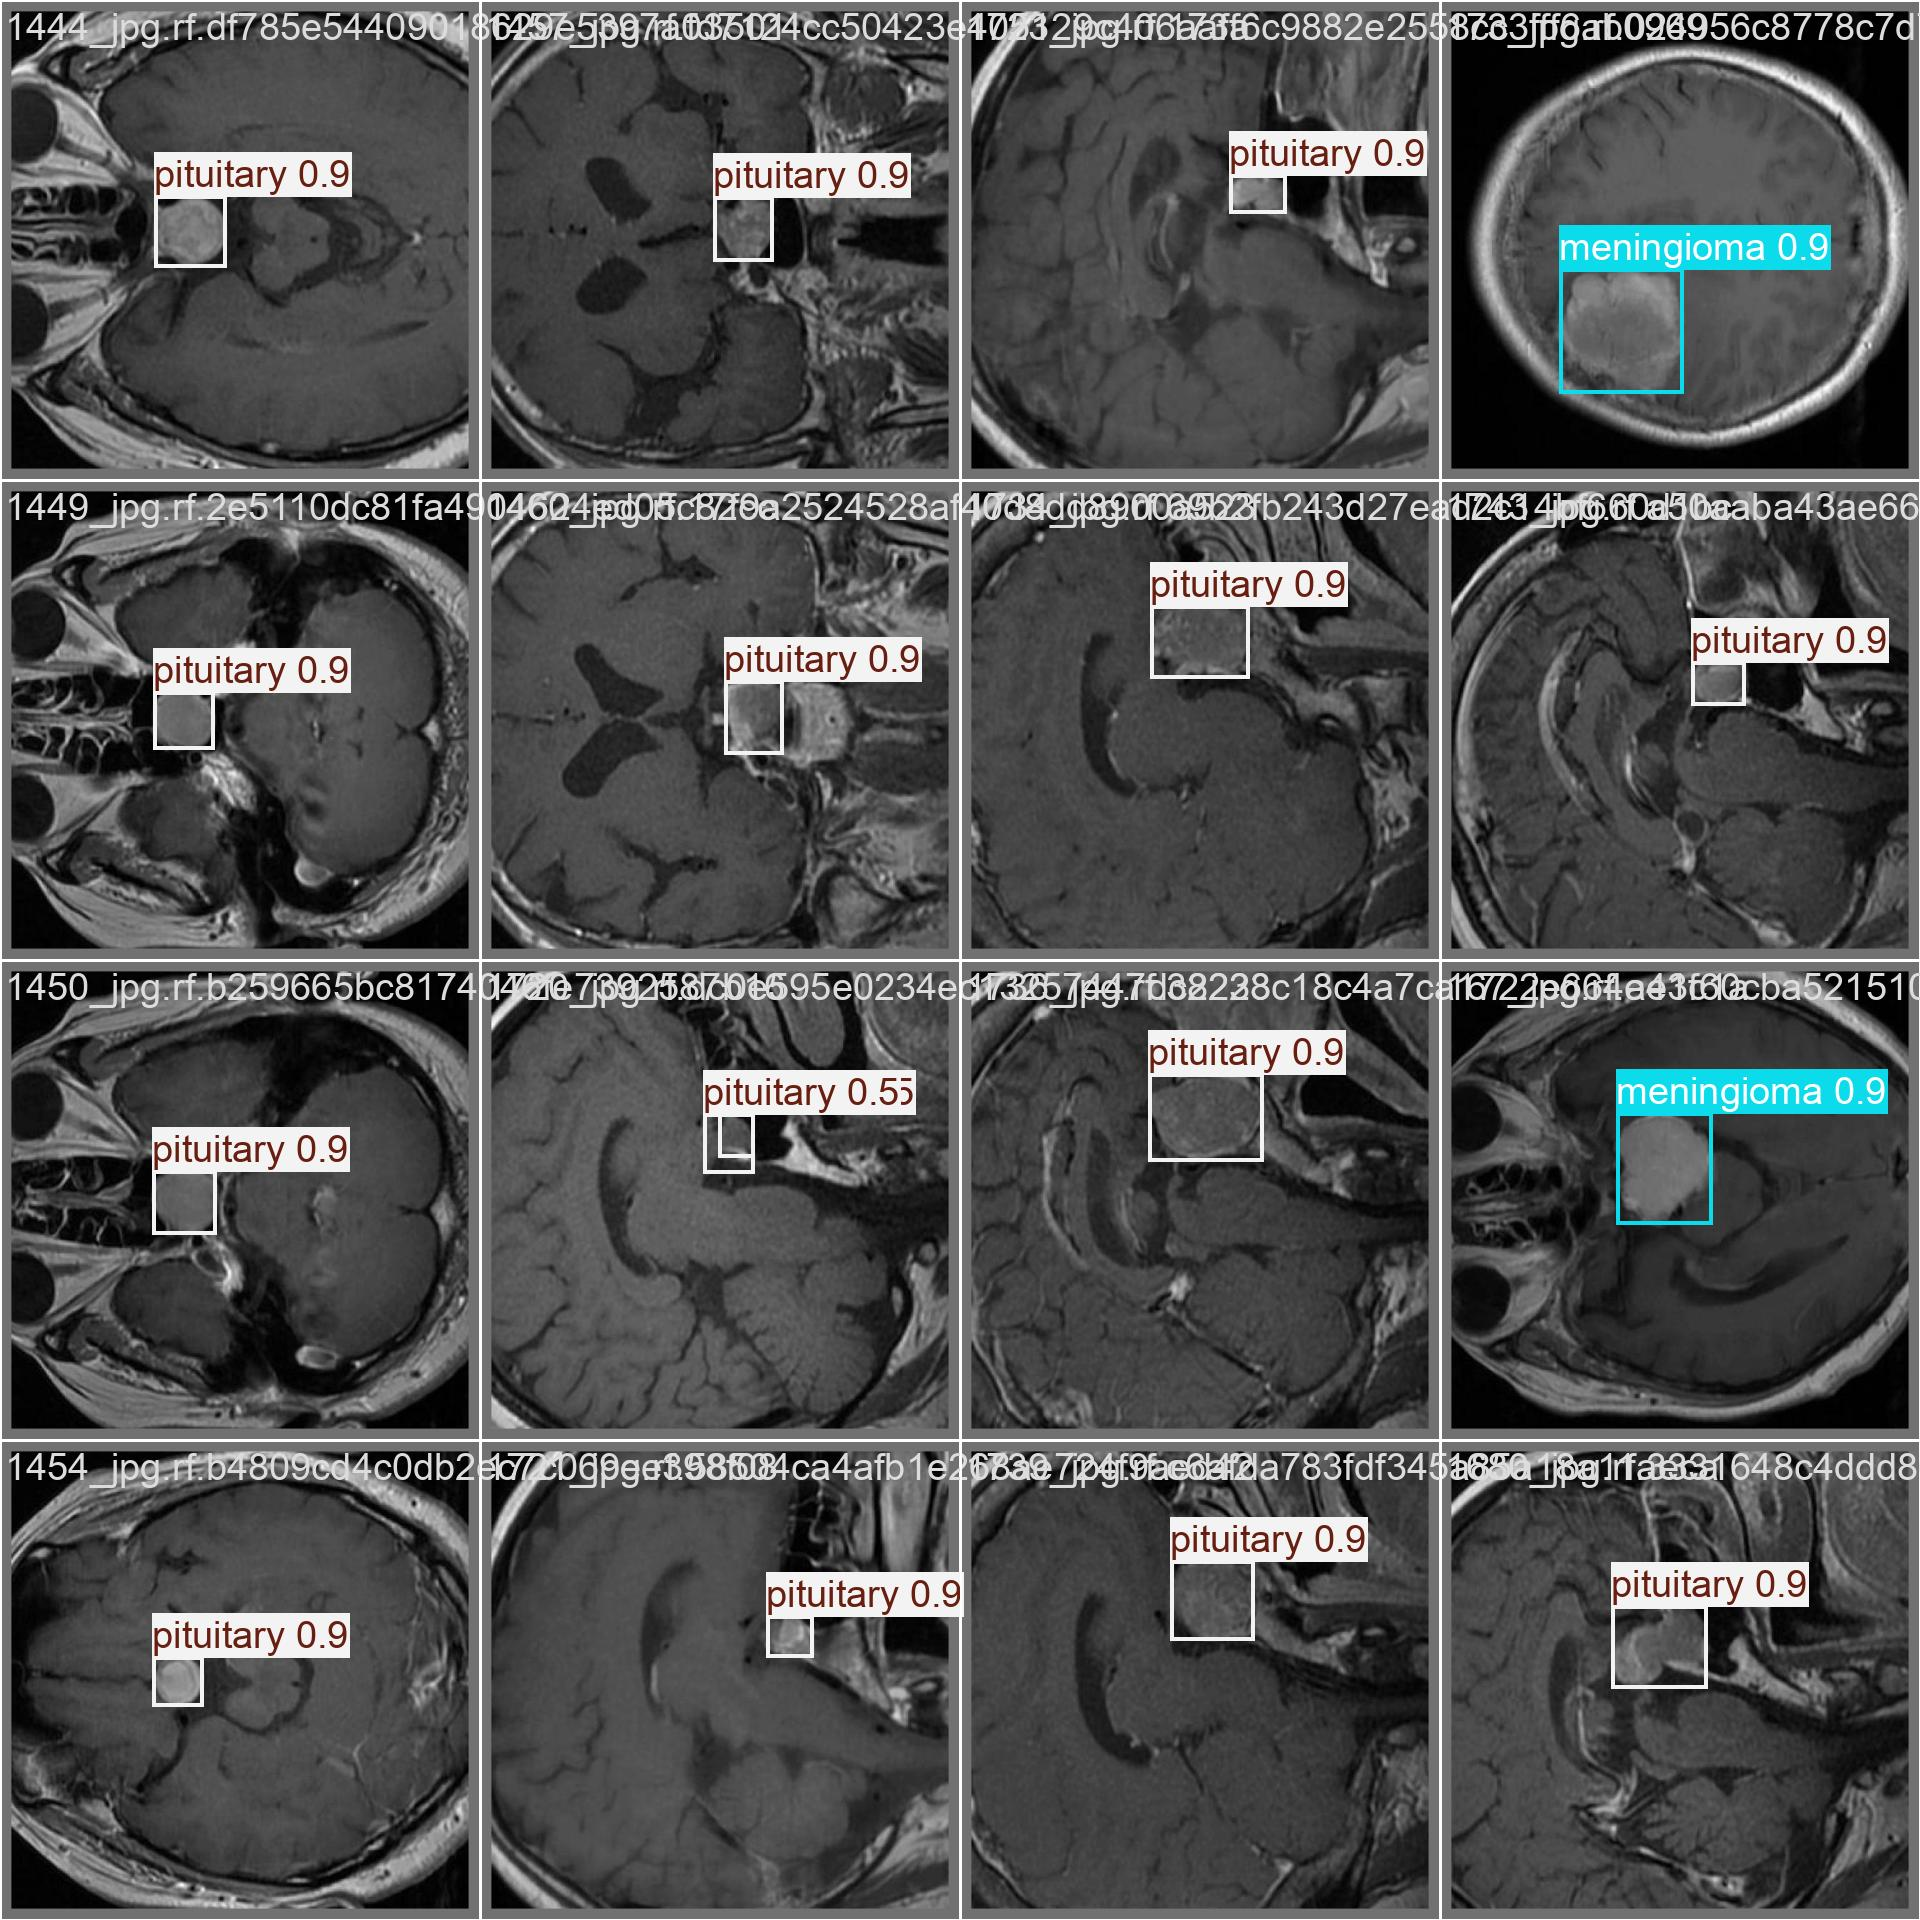

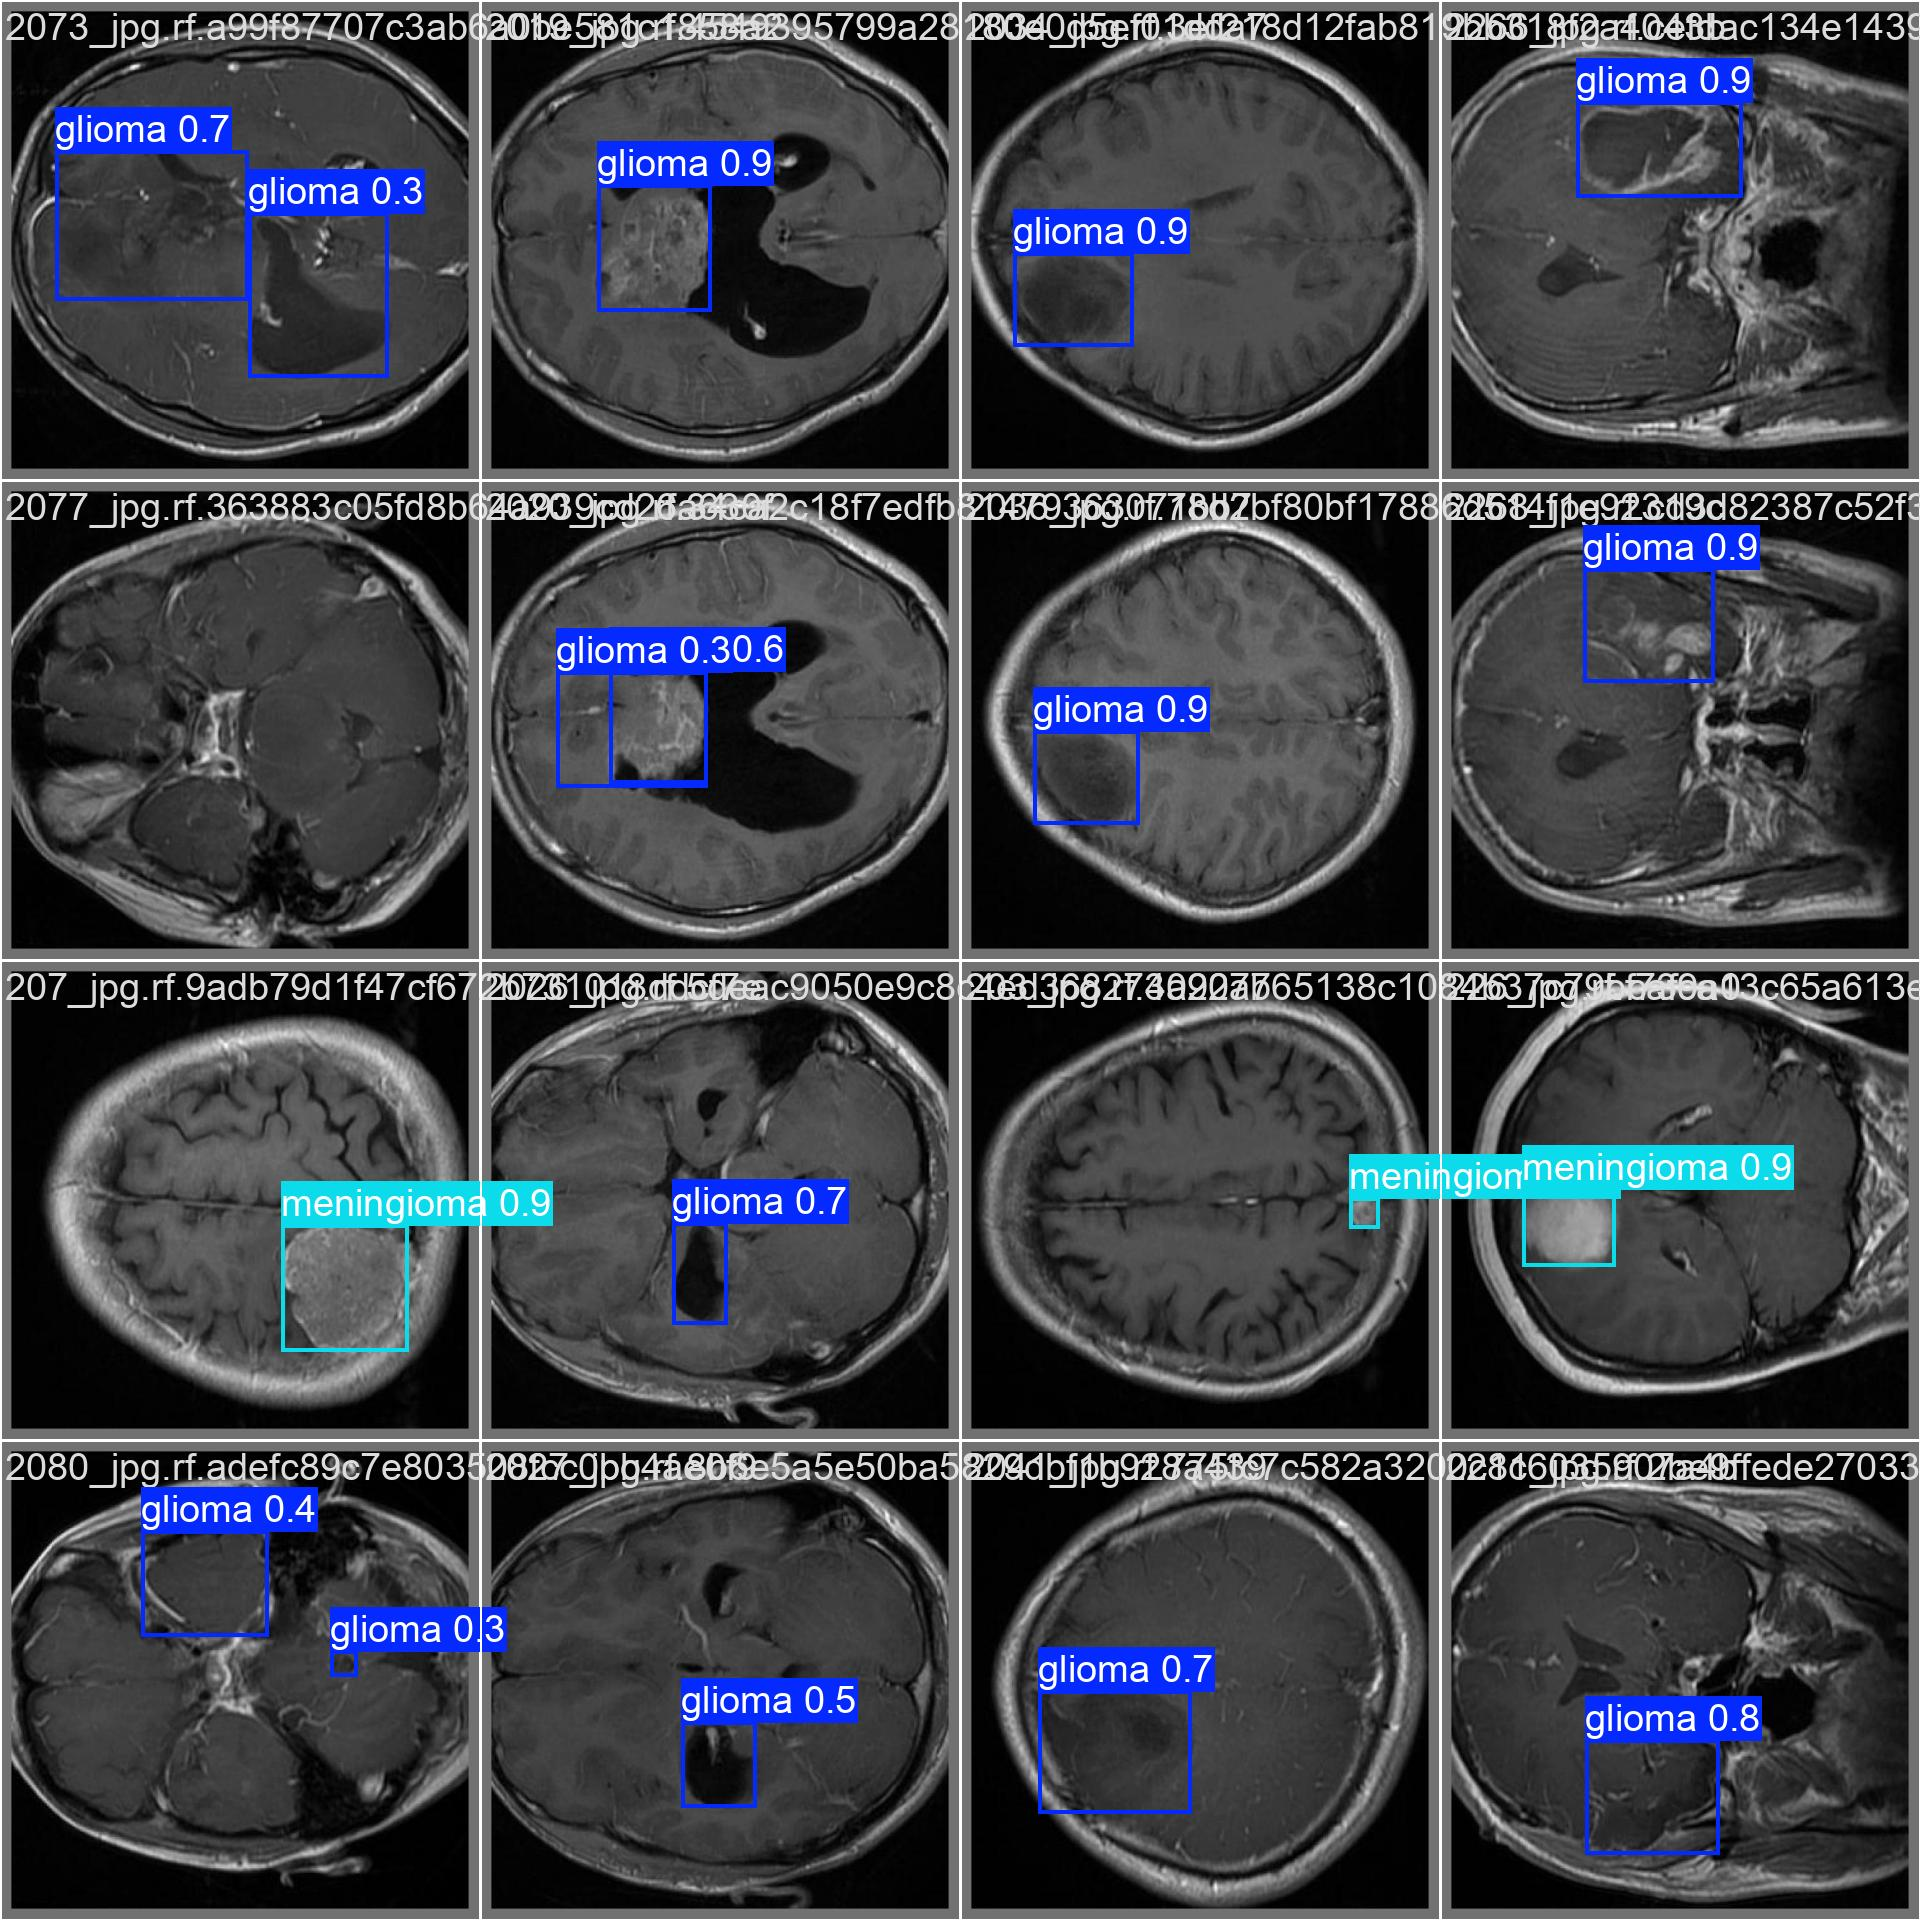

In [26]:
# 6.4 Qualitative Results (Validation Batch Images)
print("\nSample Predictions from Validation")
val_batch_images = glob.glob(os.path.join(results_dir, 'val_batch*_pred.jpg'))
if val_batch_images:
    for img_path in sorted(val_batch_images)[:3]: # Display first 3 batches
        display(Image(filename=img_path))
else:
    print("No validation batch images found.")
